In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint
from scipy import constants

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20,10)

pal = sns.color_palette("Paired")

S = np.linspace(0, 50, 100)

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%load_ext julia.magic
import IPython
ip = IPython.get_ipython()
j = ip.magics_manager.registry['JuliaMagics'].julia
# gets the Julia session associated with cell magics

j.using('DifferentialEquations')
j.using('NLsolve')

Initializing Julia interpreter. This may take some time...


# Constants

In [3]:
c = constants.c
h = constants.h
m_e = 1e6*constants.physical_constants['electron mass energy equivalent in MeV'][0]/c**2 #0.511 MeV
m_i = 1e6*constants.physical_constants['proton mass energy equivalent in MeV'][0]/c**2
e = constants.e
kb = constants.physical_constants['Boltzmann constant in eV/K'][0]

kappa_0 = 2000;
gamma = 5
Liz = 5
S = np.linspace(0.0, 50, 1000)

e0 = 8.85e-12

In [4]:
c_s = lambda T : np.sqrt(2*T/m_i)

# Boundary Conditions

In [9]:
T_t = 10
n_t = 1e19
c_st = c_s(T_t)
q_t = np.abs(gamma*n_t*c_st*T_t*e)
q_t

2.1884735806016122e+25

Accoring to Stangeby Ch. 11 we have 4 equations for the conduction limited SOL:


\begin{equation}
1.\quad q = -\kappa_0 T^{\frac{5}{2}} \frac{\mathrm{d}T}{\mathrm{d} s}
\end{equation}

\begin{equation}
2.\quad \Gamma(s) = n_t c_{st} + \int_0^s \mathrm{d}s' S_p(s')
\end{equation}

\begin{equation}
3.\quad n(s)\left[2kT(s) + m_iv(s)^2 \right] = 4n_tkT_t
\end{equation}

\begin{equation}
4.\quad q_t = \gamma n_t c_{st}kT_t
\end{equation}


# Temperature

Solving 1. analytically gives

\begin{equation}
T(s) = \left(T_t^{\frac{7}{2}} + \frac{7}{2}\frac{q_ts}{\kappa_0} \right)^{\frac{2}{7}} 
\end{equation}

In [6]:
T = lambda s : (T_t**(7/2) + (7*q_t*s)/(2*kappa_0) )**(2/7)

# Flux

\begin{align}
\quad \Gamma(s) &= n_t c_{st} + \int_0^s \mathrm{d}s' S_p(s')\\
&=\begin{cases}
n_tc_{st}(1-s/L_{iz}), \qquad0 \le s \le L_{iz} \\
0, \qquad L_{iz} \lt s \le L\\
\end{cases}\\
&\approx n_tc_{st}e^{-\frac{s}{L_{iz}}}
\end{align}

In [7]:
Gamma = lambda s : -n_t*c_s(T_t)*np.exp(-s/Liz)
GammaPW = lambda s: n_t*c_s(T_t)*np.heaviside(Liz-s,0)*(1-s/Liz)

# Density

\begin{equation}
c_s^2n^2 - 2c_{st}^2n_tn + \Gamma^2 = 0
\end{equation}

\begin{equation}
n(s) = \frac{n_t}{(c_s/c_{st})^2} \left[1 + \sqrt{1 - \left(\frac{c_s}{c_{st}}\right)^2 \left(\frac{\Gamma}{n_t c_{st}}\right)^2} \right]
\end{equation}

\begin{equation}
\alpha = \frac{4n_tkT_t}{m_i}
\end{equation}

In [8]:
alpha = 2 * n_t * c_s(T_t)**2
#n = lambda s: (1/(2*c_s(T(s))**2))*(alpha + np.sqrt(alpha**2 - 4*(Gamma(s)*c_s(T(s)))**2))
n = lambda s : n_t * (c_s(T(s))/c_st)**-2 * (1 + np.sqrt(1 - (c_s(T(s))/c_st)**2 * (Gamma(s)/(n_t*c_st))**2))

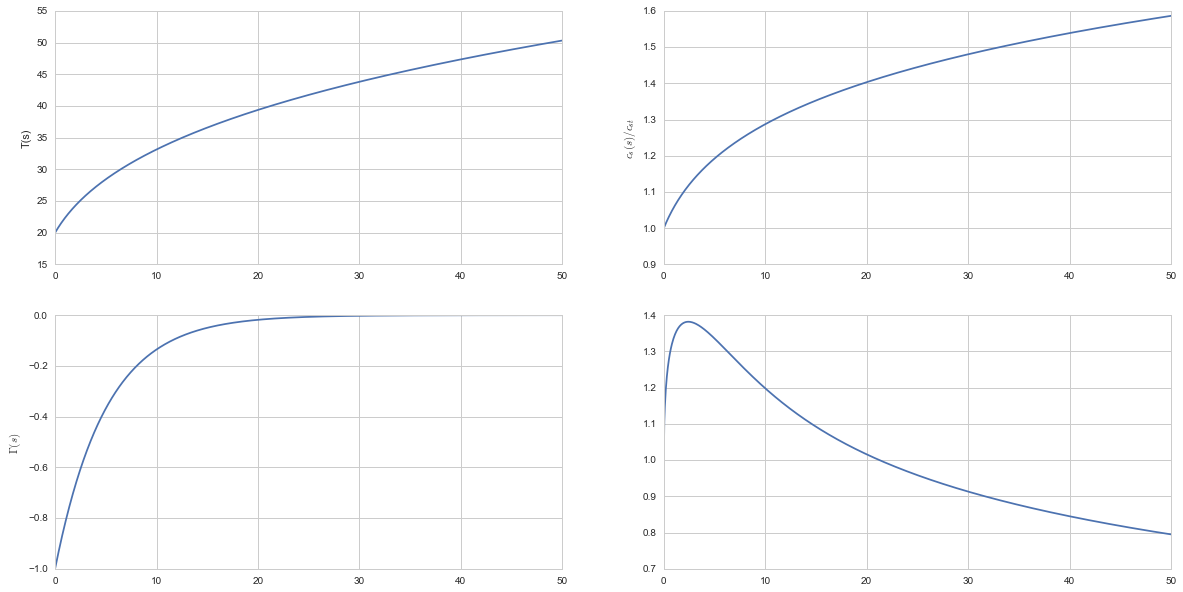

In [9]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
#fig.set_size_inches((20,10))

axes[0].plot(S, T(S)) 
axes[1].plot(S, c_s(T(S))/c_st)
axes[2].plot(S, Gamma(S)/(n_t*c_st)) 
#axes[2].plot(S, GammaPW(S), '--')

axes[3].plot(S, n(S)/n_t)
#axes[3].plot(S, (c_s(T(S))/c_st)**2, '.')
#axes[3].plot(S, (Gamma(S)/(n_t*c_st))**2, '.')
#axes[3].plot(S, (c_s(T(S))/c_st)**2*(Gamma(S)/(n_t*c_st))**2, '.')



axes[0].set_ylabel("T(s)")
axes[2].set_ylabel("$\Gamma(s)$")
axes[1].set_ylabel("$c_{s}(s)/c_{st}$")

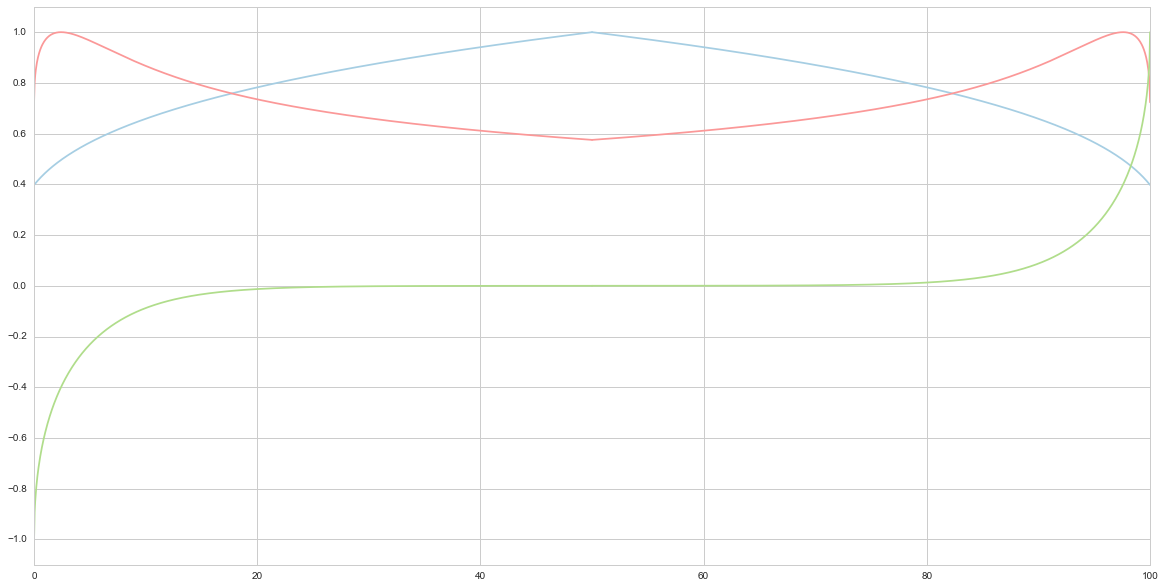

In [10]:
plt.plot(S, T(S)/np.max(T(S)),c=pal[0], label='T'); plt.plot(100-S, T(S)/np.max(T(S)),c=pal[0], label='T')
plt.plot(S, n(S)/np.max(n(S)),c=pal[4], label='n'); plt.plot(100-S, n(S)/np.max(n(S)),c=pal[4], label='n')
plt.plot(S, Gamma(S)/(n(S)*c_s(T(S))),c=pal[2], label='M'); plt.plot(100-S, -Gamma(S)/(n(S)*c_s(T(S))),c=pal[2], label='M')

plt.yticks(np.linspace(-1, 1, 11))
plt.xlim((0,100))
plt.ylim((-1.1,1.1))
plt.gcf().set_size_inches((20, 10))

# Implicit DAE Solving

In [11]:
j.eval("T_t,n_t,c_st,q_t = {}".format((T_t,n_t,c_st,q_t)))
j.eval("c,h,m_e,m_i,e,kb = {}".format((c,h,m_e,m_i,e,kb)))
j.eval("kappa_0,gamma,Liz = {}".format((kappa_0,gamma,Liz)))

(2000, 5, 5)

In [12]:
%%julia

function f(t,u,du,out)
    T, n, v = u
    dT, dn, dv = du  
    out[1] = (-2.5*T*e*n*v + kappa_0*T^(2.5)*dT - q_t)    # Energy conservation
    out[2] = n*v + n_t*c_st*exp(-t/Liz)    # Continuity
    out[3] = m_i*n*v^2 + 2*n*T - 4*n_t*T_t # Pressure conservation
end

# Initial Conditions
tspan = (0.0,50.0)
u0 = [T_t, n_t, -c_st]

array([  2.00000000e+01,   1.00000000e+19,  -6.18993804e+04])

In [13]:
%%julia

# Computes the inital temperature
# gradient from q
function f0(du, out)
    t = [0.,0.,0.]
    f(0,u0,[du[1], 0,0],t)
    out[1] = t[1]
end
res = nlsolve(f0, [1.])
du0 = [res.zero[1], 0., 0.] 
res
#du0 = [ q_t/(kappa_0*T_t^2.5) , 0., 0.]

<PyCall.jlwrap Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0]
 * Zero: [1.386]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3>

In [14]:
%%julia

differential_vars = [true,false,false]
prob = DAEProblem(f,u0,du0,tspan,differential_vars=differential_vars)
sol = solve(prob, IDA(), saveat=0.01)
"Done"

'Done'

(5001, 3)


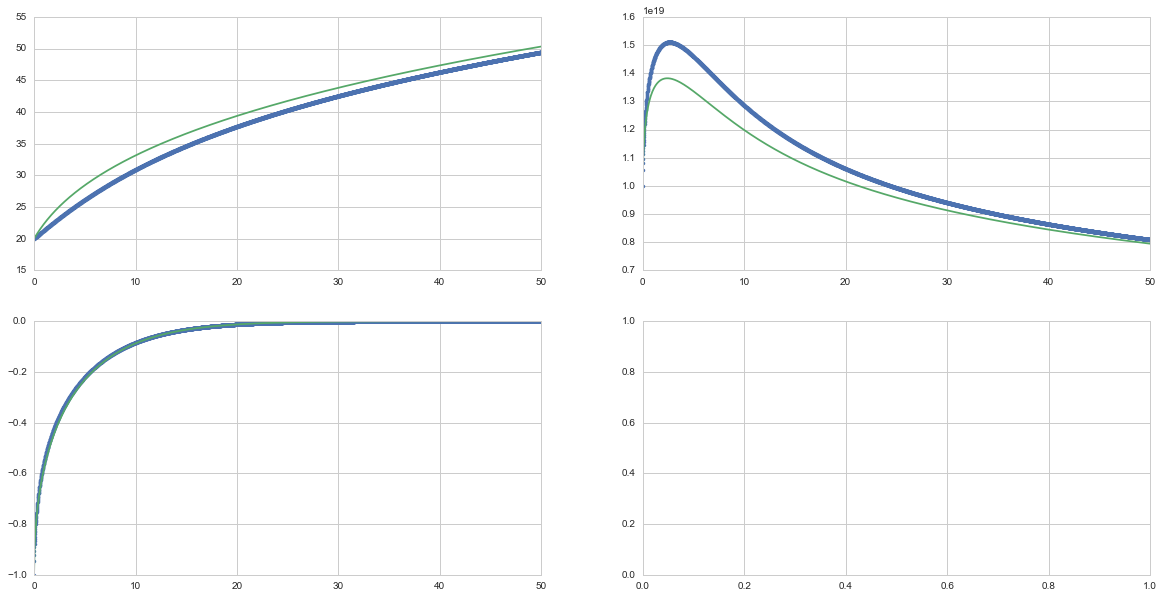

In [15]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()

t = %julia sol.t
u = %julia sol.u
u = np.array(u)
print(u.shape)

axes[0].plot(t, u[:,0], '.'); axes[0].plot(S, T(S))  
axes[1].plot(t, u[:,1], '.'); axes[1].plot(S, n(S)) 
axes[2].plot(t, u[:,2]/c_s(u[:,0]), '.'); axes[2].plot(S, Gamma(S)/(n(S)*c_s(T(S)))) 

In [16]:
#import julia
#j = julia.Julia(debug=False)
#j.using('DifferentialEquations')
#p = j.DAEProblem(f,u0, du0, tspan,differential_vars=[True,True,False])